In [13]:
# Set GPU 

from IPython.core.debugger import set_trace
import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "0" # change to -1 if you only want use CPU

In [14]:
# Modify config to chance the GPU memory settings
# such that it grows dynamically 

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = tf.Session(config=config)

In [15]:
# This is to check that exactly one GPU is available to Keras
from keras import backend as K
K.set_session(session)
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:XLA_GPU:0']

In [16]:
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
%matplotlib inline

import time

from sklearn.utils import shuffle

import tensorflow as tf
from keras import backend as K
from keras import Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda
from keras.models import Sequential
from keras.regularizers import l2
from keras.initializers import glorot_normal, RandomNormal

In [17]:
class loadImage():
    
    def __init__(self, path):
        self.path = path
        self.X, self.y, self.c = self.loadimgs(self.path)
        
    # Loading images
    def loadimgs(self, path, n = 0):
        '''
        path => Path of train directory or test directory
        '''
        X=[]
        y = []
        cat_dict = {}
        lang_dict = {}
        curr_y = n

        # Load every alphabet seperately to isolate them later
        for alphabet in os.listdir(path):
            #print("loading alphabet: " + alphabet)
            lang_dict[alphabet] = [curr_y,None]
            alphabet_path = os.path.join(path,alphabet)

            # every letter/category has it's own column in the array, so load seperately
            for letter in os.listdir(alphabet_path):
                cat_dict[curr_y] = (alphabet, letter)
                category_images=[]
                letter_path = os.path.join(alphabet_path, letter)

                # read all the images in the current category
                for filename in os.listdir(letter_path):
                    image_path = os.path.join(letter_path, filename)
                    image = imread(image_path)
                    category_images.append(image)
                    y.append(curr_y)
                try:
                    X.append(np.stack(category_images))
                # edge case  - last one
                except ValueError as e:
                    print(e)
                    print("error - category_images:", category_images)
                curr_y += 1
                lang_dict[alphabet][1] = curr_y - 1
        y = np.vstack(y)
        X = np.stack(X)
        
        return X,y,lang_dict
    
    def loadAsPickle(self, pickle_name):
        with open(os.path.join(save_path, "{}.pickle".format(pickle_name)), 'wb') as f:
            pickle.dump( self.X, f, pickle.HIGHEST_PROTOCOL )
            pickle.dump( self.y, f, pickle.HIGHEST_PROTOCOL )
            pickle.dump( self.c, f, pickle.HIGHEST_PROTOCOL )
            
    def loadFromPickle(self, pickle_name):
        with open(os.path.join(save_path, "{}.pickle".format(pickle_name)), "rb") as f:
            self.X = pickle.load(f)
            self.y = pickle.load(f)
            self.c = pickle.load(f)

In [18]:
class SiameseNetwork():
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
        #self.siamese_model = self._get_siamese_model()

    # Network creation
    def get_siamese_model(self):
        """
            Model architecture
        """

        # Define the tensors for the two input images
        left_input = Input(self.input_shape)
        right_input = Input(self.input_shape)
        
        # Convolutional Neural Network
        model = Sequential()
        model.add(Conv2D(64, 
                         (10,10), 
                         activation='relu', 
                         input_shape=self.input_shape,
                         kernel_initializer=RandomNormal(mean=0.0, stddev=1e-2),
                         bias_initializer=RandomNormal(mean=0.5, stddev=1e-2), 
                         kernel_regularizer=l2(2e-4)))
        model.add(MaxPooling2D())
        model.add(Conv2D(128, 
                         (7,7), 
                         activation='relu',
                         kernel_initializer=RandomNormal(mean=0.0, stddev=1e-2),
                         bias_initializer=RandomNormal(mean=0.5, stddev=1e-2), 
                         kernel_regularizer=l2(2e-4)))
        model.add(MaxPooling2D())
        model.add(Conv2D(128, 
                         (4,4), 
                         activation='relu', 
                         kernel_initializer=RandomNormal(mean=0.0, stddev=1e-2),
                         bias_initializer=RandomNormal(mean=0.5, stddev=1e-2), 
                         kernel_regularizer=l2(2e-4)))
        model.add(MaxPooling2D())
        model.add(Conv2D(256, 
                         (4,4), 
                         activation='relu', 
                         kernel_initializer=RandomNormal(mean=0.0, stddev=1e-2),
                         bias_initializer=RandomNormal(mean=0.5, stddev=1e-2), 
                         kernel_regularizer=l2(2e-4)))
        model.add(Flatten())
        model.add(Dense(4096, 
                        activation='sigmoid',
                        kernel_regularizer=l2(1e-3),
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.2),
                        bias_initializer=RandomNormal(mean=0.5, stddev=1e-2) ))

        # Generate the encodings (feature vectors) for the two images
        encoded_l = model(left_input)
        encoded_r = model(right_input)

        # Add a customized layer to compute the absolute difference between the encodings
        L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([encoded_l, encoded_r])

        # Add a dense layer with a sigmoid unit to generate the similarity score
        prediction = Dense(1,
                           activation='sigmoid', 
                           bias_initializer=RandomNormal(mean=0.5, stddev=1e-2))(L1_distance)

        # Connect the inputs with the outputs
        siamese_net = Model(inputs=[left_input,right_input],
                            outputs=prediction)
        
        return siamese_net


In [19]:
class trainExamples():
    
    def __init__(self, batch_size, s, trainClass, valClass):
        self.batch_size = batch_size
        self.s = s
        self.trainClass = trainClass
        self.valClass = valClass
        (self.pairs, self.targets) = self.get_batch()
    
    def generate(self):
        """
        a generator for batches, so model.fit_generator can be used.
        """
        while True:
            pairs, targets = self._get_batch()
            yield (pairs, targets)
        
    
    # Training example creation
    def get_batch(self):
        """
        Create batch of n pairs, half same class, half different class
        """
        if self.s == 'train':
            X = self.trainClass.X
            categories = self.trainClass.c
        else:
            X = self.valClass.X
            categories = self.valClass.c
        n_classes, n_examples, w, h = X.shape

        # randomly sample several classes to use in the batch
        categories = np.random.choice(n_classes,size=(self.batch_size,),replace=False)

        # initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((self.batch_size, h, w, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((self.batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[self.batch_size//2:] = 1
        for i in range(self.batch_size):
            category = categories[i]
            idx_1 = np.random.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = np.random.randint(0, n_examples)

            # pick images of same class for 1st half, different for 2nd
            if i >= self.batch_size // 2:
                category_2 = category  
            else: 
                # add a random number to the category modulo n classes to ensure 2nd image has a different category
                category_2 = (category + np.random.randint(1, n_classes)) % n_classes

            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)

        return pairs, targets

In [20]:
class valExamples():
    
    def __init__(self, model, N, k, s, verbose, language, trainClass, valClass):
        self.model = model
        self.N = N
        self.k = k
        self.s = s
        self.verbose = verbose
        self.language = language
        self.trainClass = trainClass
        self.valClass = valClass
    
    def test_oneshot(self):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if self.verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(self.k,self.N))
        for i in range(self.k):
            inputs, targets = self._make_oneshot_task()
            probs = self.model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct) / self.k
        
        if self.verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct, self.N))
        
        return percent_correct
    
    def _make_oneshot_task(self):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        if self.s == "train":
            X = self.trainClass.X
            categories = self.trainClass.c
        else:
            X = self.valClass.X
            categories = self.valClass.c

        n_classes, n_examples, w, h = X.shape

        indices = np.random.randint(0, n_examples,size=(self.N,))
        if self.language is not None: # if language is specified, select characters for that language
            low, high = categories[self.language]
            if self.N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(self.language, self.N))
            categories = np.random.choice(range(low, high), size=(self.N,), replace=False)
        else: # if no language specified just pick a bunch of random letters
            categories = np.random.choice(range(n_classes), size=(self.N,), replace=False)            

        true_category = categories[0]
        ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
        test_image = np.asarray([X[true_category, ex1, :,:]] * self.N).reshape(self.N, w, h, 1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(self.N, w, h, 1)
        targets = np.zeros((self.N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, targets

In [21]:
def check_pairs(seed, trainings, num_rows):
    np.random.seed(seed)
    rand_image_nums = np.random.choice(trainings.pairs[0].shape[0], size=(10,))
    rand_images_0 = trainings.pairs[0][rand_image_nums]
    rand_images_1 = trainings.pairs[1][rand_image_nums]
    rand_targets = trainings.targets[rand_image_nums]

    print("Couple of image pairs to check....")
    print("\n")
    for i in range(num_rows):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5,5))
        print("Pair #{}".format(i+1))
        ax1.imshow(rand_images_0[i].reshape(105,105), cmap='gray')
        ax2.imshow(rand_images_1[i].reshape(105,105), cmap='gray')
        print("Target labeling is: {}".format(int(rand_targets[i])))
        plt.show() 

In [22]:
def runSiameseTests():
    
    evaluate_every = 200 # interval for evaluating on one-shot tasks
    batch_size = 32
    n_iter = 20000 # No. of training iterations
    N_way = 20 # how many classes for testing one-shot tasks
    n_val = 250 # how many one-shot tasks to validate on
    best = 0.0
    learning_rate = 0.00005

    # File paths
    train_path = "images_background"
    val_path = "images_evaluation"
    save_path = "save_data/"

    trainImages = loadImage(train_path)
    print("Training images have been loaded.")
    valImages = loadImage(val_path)
    print("Validation images have been loaded.")
    
    network = SiameseNetwork(input_shape=(105,105,1))
    siamese_model = network.get_siamese_model()
    
    trainings = trainExamples(batch_size=batch_size, 
                              s="train", 
                              trainClass=trainImages, 
                              valClass=valImages)
    check_pairs(seed=1, trainings=trainings, num_rows=2)
    
    siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate))
    siamese_model.summary()

    print("Starting training process!")
    print("-------------------------------------")
    for i in range(1, n_iter+1):
        
        t_start = time.time()
        trainings = trainExamples(batch_size=batch_size, 
                                  s="train", 
                                  trainClass=trainImages, 
                                  valClass=valImages)
        
        loss = siamese_model.train_on_batch(trainings.pairs, trainings.targets)

        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
            print("Train Loss: {}".format(loss)) 
            
            validation = valExamples(model = siamese_model, 
                                     N = N_way, 
                                     k = n_val, 
                                     s = "val", 
                                     verbose=True, 
                                     language=None, 
                                     trainClass=trainImages, 
                                     valClass=valImages)
            
            val_acc = validation.test_oneshot()
            if val_acc >= best:
                print("Validation Accuracy: {}".format(val_acc))
                best = val_acc
        
    siamese_model.save('siamese_model_v2.h5')

Training images have been loaded.
Validation images have been loaded.
Couple of image pairs to check....


Pair #1
Target labeling is: 0


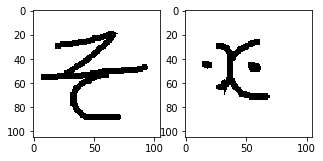

Pair #2
Target labeling is: 0


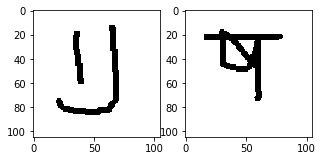

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         


 ------------- 

Time for 5800 iterations: 0.016419072945912678 mins
Train Loss: 139.86444091796875
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.8% 20 way one-shot learning accuracy 

Validation Accuracy: 54.8

 ------------- 

Time for 6000 iterations: 0.017873120307922364 mins
Train Loss: 127.4665756225586
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 46.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 6200 iterations: 0.01801137924194336 mins
Train Loss: 116.1395492553711
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 45.6% 20 way one-shot learning accuracy 


 ------------- 

Time for 6400 iterations: 0.01768076022466024 mins
Train Loss: 105.62488555908203
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 51.2% 20 way one-shot learning accuracy 


 ------------- 

Time for 6600 iterations: 0.0171238660812377


 ------------- 

Time for 12800 iterations: 0.01719930171966553 mins
Train Loss: 4.061141490936279
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 13000 iterations: 0.017326772212982178 mins
Train Loss: 3.5969502925872803
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 69.2% 20 way one-shot learning accuracy 


 ------------- 

Time for 13200 iterations: 0.018668075402577717 mins
Train Loss: 3.280515432357788
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 


 ------------- 

Time for 13400 iterations: 0.018077802658081055 mins
Train Loss: 2.9459192752838135
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 13600 iterations: 0.0175110658009847 mins
Train Loss: 2.

Got an average of 77.2% 20 way one-shot learning accuracy 

Validation Accuracy: 77.2

 ------------- 

Time for 20000 iterations: 0.018529343605041503 mins
Train Loss: 0.5471328496932983
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way one-shot learning accuracy 



In [23]:
runSiameseTests()